Compare the emission line data from GAMA to the emission line data from SDSS DR7 

In [1]:
import os
import h5py
import subprocess
import numpy as np 

from astropy.io import fits
from pydl.pydlutils.spheregroup import spherematch

from feasibgs import util as UT
from feasibgs import catalogs as Cat

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in GAMA-Legacy Catalog

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read()
cataid = gleg['gama-photo']['cataid'] # GAMA catalog id of each object
ngal = len(cataid)

Read in SDSS `spAll` and `spAll-line` file (preprocessed with a simple redshift cut and rewritten to hdf5 for sanity). 
`spAll` contains the $RA$ and $Dec$ of the SDSS data and `spAll-line` contains the SDSS emission line data

In [4]:
f_sdss = h5py.File(''.join([UT.dat_dir(), 'sdss/spAll-v5_7_0.zcut.hdf5']), 'r') 
ra_sdss = f_sdss['ra'].value
dec_sdss = f_sdss['dec'].value 

In [130]:
print f_sdss['plate'].value
print f_sdss['mjd'].value

[3586 3586 3586 ... 7457 7457 7457]
[55181 55181 55181 ... 56746 56746 56746]


In [5]:
f_sdss_emline = h5py.File(''.join([UT.dat_dir(), 'sdss/spAllLine-v5_7_0.zcut.hdf5']), 'r')
print f_sdss_emline.keys()

[u'fiberid', u'linearea', u'linearea_err', u'linechi2', u'linecontlevel', u'linecontlevel_err', u'linedof', u'lineew', u'lineew_err', u'linename', u'linenpixleft', u'linenpixright', u'linesigma', u'linesigma_err', u'linewave', u'linez', u'linez_err', u'mjd', u'plate']


In [6]:
sdss_linearea = f_sdss_emline['linearea'].value
sdss_linesigma = f_sdss_emline['linesigma'].value

In [7]:
sdss_linewave = f_sdss_emline['linewave'].value[:,0]

emission lines in the SDSS data

In [8]:
for i in range(f_sdss_emline['linename'].value.shape[1]): 
    print('%i -- %s' % (i, f_sdss_emline['linename'].value[0,i]))

0 -- Ly_alpha     
1 -- N_V 1240     
2 -- C_IV 1549    
3 -- He_II 1640   
4 -- C_III] 1908  
5 -- Mg_II 2799   
6 -- [O_II] 3725  
7 -- [O_II] 3727  
8 -- [Ne_III] 3868
9 -- H_epsilon    
10 -- [Ne_III] 3970
11 -- H_delta      
12 -- H_gamma      
13 -- [O_III] 4363 
14 -- He_II 4685   
15 -- H_beta       
16 -- [O_III] 4959 
17 -- [O_III] 5007 
18 -- He_II 5411   
19 -- [O_I] 5577   
20 -- [N_II] 5755  
21 -- He_I 5876    
22 -- [O_I] 6300   
23 -- [S_III] 6312 
24 -- [O_I] 6363   
25 -- [N_II] 6548  
26 -- H_alpha      
27 -- [N_II] 6583  
28 -- [S_II] 6716  
29 -- [S_II] 6730  
30 -- [Ar_III] 7135


spherematch the SDSS $RA$ and $Dec$ to the GAMA $RA$ and $Dec$

In [9]:
m_sdss, m_gleg, d_match = spherematch(ra_sdss, dec_sdss, 
                                      gleg['gama-photo']['ra'], gleg['gama-photo']['dec'], 0.000277778)

In [10]:
print('%i matching galaxies' % len(m_sdss))

899 matching galaxies


check that their RA and Dec match

In [11]:
for i_sdss, i_gleg in zip(m_sdss, m_gleg): 
    if ((np.abs(gleg['gama-photo']['ra'][i_gleg] - ra_sdss[i_sdss]) > 0.01) or 
        (np.abs(gleg['gama-photo']['dec'][i_gleg] - dec_sdss[i_sdss]) > 0.01)): 
        print('GLEG: %f, %f' % (gleg['gama-photo']['ra'][i_gleg], gleg['gama-photo']['dec'][i_gleg]))
        print('SDSS: %f, %f' % (ra_sdss[i_sdss], dec_sdss[i_sdss]))
        print('---')

In [12]:
emline_sdss_index = [6, 7, 15, 16, 17, 25, 26, 27, 28, 29]
emline_gleg_key = ['oiib', 'oiir', 'hb', 'oiiib', 'oiiir', 'niib', 'ha', 'niir', 'siib', 'siir']
emline_lambda = [3726., 3728., 4861., 4959., 5007., 6548., 6563., 6584., 6716., 6731.]

Comparing the SDSS and GAMA emission line measurements: 

GAMA: 
- line flux is in units of $10^{−17} erg s^{−1} cm^{−2}$
- integrated line flux is in units of $10^{−17} erg s^{−1}$ cm^{−2}$

SDSS: 
- `linearea` is in units of ($10^{-17} erg/cm^2/s/A$)*Angstrom

In [124]:
def emlineComparison(em_keys, integrated=False): 
    fig = plt.figure(figsize=(4*len(em_keys),4))
    for i, k in zip(range(len(em_keys)), em_keys):
        sub1 = fig.add_subplot(1,len(em_keys),i+1)

        # GAMA emission line properties
        if not integrated: 
            gama_emline_integ = gleg['gama-spec'][k][m_gleg].flatten()
        else: 
            gama_emline_integ = gleg['gama-spec']['i'+k][m_gleg].flatten()        
        gama_emline_sigma = gleg['gama-spec'][k+'sig'][m_gleg].flatten()

        # SDSS emission line properties
        i_em = emline_gleg_key.index(k)
        sdss_emline_integ = sdss_linearea[m_sdss,emline_sdss_index[i_em]]
        sdss_emline_sigma = sdss_linewave[emline_sdss_index[i_em]] * sdss_linesigma[m_sdss,emline_sdss_index[i_em]]/(299792.- sdss_linesigma[m_sdss,emline_sdss_index[i_em]])
        #sdss_linesigma[m_sdss,emline_sdss_index[i_em]]

        has_gamaem = (gama_emline_integ != -99.)
        has_sdssem = (sdss_emline_integ > 0.)

        has_em = has_gamaem & has_sdssem 
        print np.mean(gama_emline_integ[has_em]/sdss_emline_integ[has_em])
        sub1.scatter(gama_emline_integ[has_em], sdss_emline_integ[has_em], s=2)
        sub1.plot([-100., 1000.], [-100., 1000.], c='k', ls='--')
        if i == 0 : sub1.set_ylabel('SDSS line flux', fontsize=25)
        sub1.set_xlabel('GAMA line flux', fontsize=20)
        sub1.set_xlim([0., 100.])
        sub1.set_ylim([0., 100.])
        sub1.set_title(k.upper(), fontsize=25)
    plt.show()

9.681192
5.146036
7.161714
52.635315
14.360282


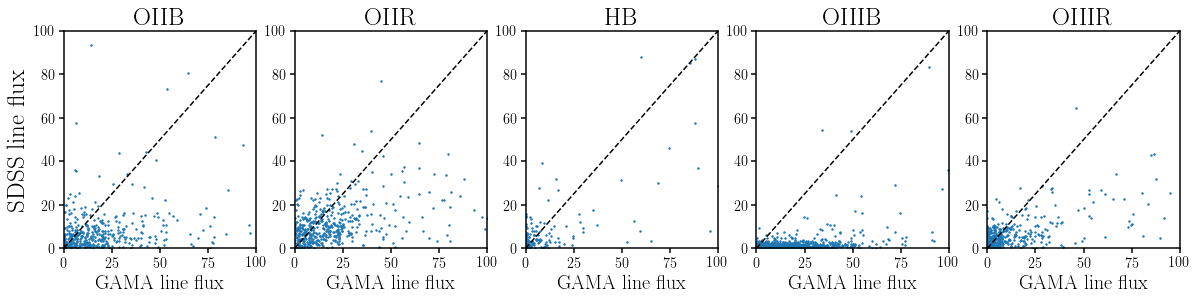

In [125]:
emlineComparison(emline_gleg_key[:5])#, integrated=True)

336.60754
11.82751
21312.182
300.3045
209.66429


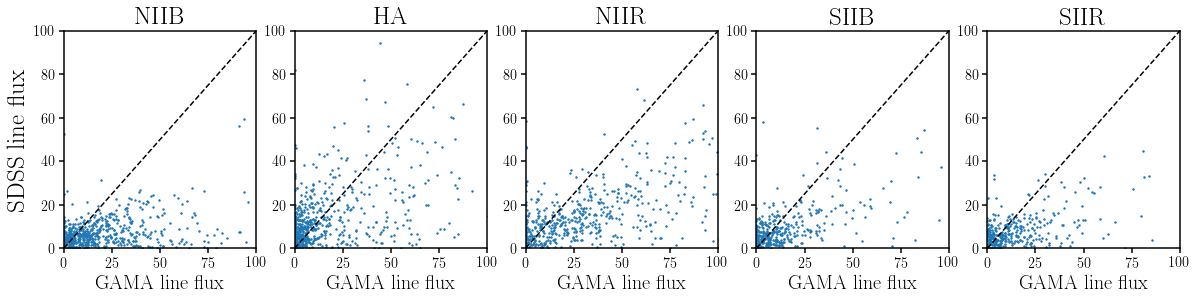

In [126]:
emlineComparison(emline_gleg_key[5:10])

Get SDSS spectra for the first 10 matches

In [122]:
sdss_specs = [] 
for i_sdss in m_sdss[:10]:
    plate_i = f_sdss_emline['plate'].value[i_sdss,0]
    mjd_i = f_sdss_emline['mjd'].value[i_sdss,0]
    fiberid_i = f_sdss_emline['fiberid'].value[i_sdss,0]
    url_i = ''.join(['https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/', 
                     str(plate_i), '/spec-', str(plate_i), '-', str(mjd_i), '-', str(fiberid_i).zfill(4), '.fits'])
    print url_i
    local_i = ''.join([UT.dat_dir(), 'gama/spectra/spec-', str(plate_i), '-', str(mjd_i), '-', str(fiberid_i).zfill(4), '.fits'])
    if not os.path.isfile(local_i): 
        subprocess.call(['curl', '-o', local_i, url_i]) 

    fspec_i = fits.open(local_i)
    sdss_specs.append(fspec_i[1].data)

https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/3815/spec-3815-55537-0654.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4793/spec-4793-55648-0012.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/3818/spec-3818-55532-0146.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4021/spec-4021-55620-0182.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4729/spec-4729-55626-0476.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4748/spec-4748-55631-0458.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4031/spec-4031-55604-0408.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4750/spec-4750-55630-0312.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/3777/spec-3777-55210-0684.fits
https://dr14.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/4

In [27]:
def justEmLines(wave, gleg_index): 
    z_gama = gleg['gama-spec']['z_helio'][gleg_index]
    emlambda_red = (1.+z_gama)*np.array(emline_lambda)
    
    flux = np.zeros(len(wave))
    for i_k, k in enumerate(emline_gleg_key): 
        if (gleg['gama-spec'][k][gleg_index] == -99.) or (gleg['gama-spec'][k+'sig'][gleg_index] < 0.): 
            continue 
        lineflux = gleg['gama-spec'][k][gleg_index]
        linesig = gleg['gama-spec'][k+'sig'][gleg_index]
        A = lineflux / np.sqrt(2.*np.pi*linesig**2)
        emline_flux = A * np.exp(-0.5*(wave-emlambda_red[i_k])**2/linesig**2)
        flux += emline_flux
    return flux

In [25]:
def justEmLines_integrated(wave, gleg_index): 
    z_gama = gleg['gama-spec']['z_helio'][gleg_index]
    emlambda_red = (1.+z_gama)*np.array(emline_lambda)
    
    flux = np.zeros(len(wave))
    for i_k, k in enumerate(emline_gleg_key): 
        if 'i'+k not in gleg['gama-spec'].keys(): 
            continue
        if (gleg['gama-spec']['i'+k][gleg_index] == -99.) or (gleg['gama-spec'][k+'sig'][gleg_index] < 0.): 
            continue 
        #print k, emlambda_red[i_k]
        lineflux = gleg['gama-spec']['i'+k][gleg_index]
        linesig = gleg['gama-spec'][k+'sig'][gleg_index]
        A = lineflux / np.sqrt(2.*np.pi*linesig**2)
        emline_flux = A * np.exp(-0.5*(wave-emlambda_red[i_k])**2/linesig**2)
        flux += emline_flux
    return flux

In [24]:
def justEmLines_SDSS(wave, gleg_index, sdss_index): 
    z_gama = gleg['gama-spec']['z_helio'][gleg_index]
    emlambda_red = (1.+z_gama)*np.array(emline_lambda)
    
    flux = np.zeros(len(wave))
    for i_k, k in enumerate(emline_gleg_key): 
        if (gleg['gama-spec'][k][gleg_index] == -99.) or (gleg['gama-spec'][k+'sig'][gleg_index] < 0.): 
            continue 
        #lineflux = gleg['gama-spec'][k][gleg_index]
        linesig = gleg['gama-spec'][k+'sig'][gleg_index]
        lineflux = sdss_linearea[sdss_index,emline_sdss_index[i_k]]
        
        A = lineflux / np.sqrt(2.*np.pi*linesig**2)
        emline_flux = A * np.exp(-0.5*(wave-emlambda_red[i_k])**2/linesig**2)
        flux += emline_flux
    return flux

==0==
3815, 55537, 654
z_gama= 0.236460


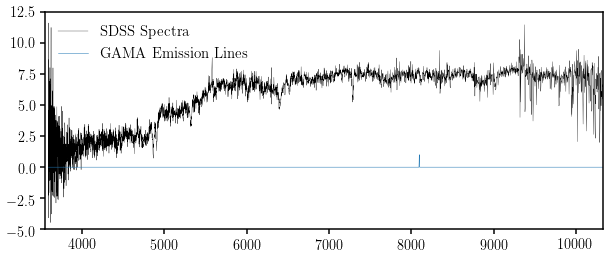

==1==
4793, 55648, 12
z_gama= 0.280410


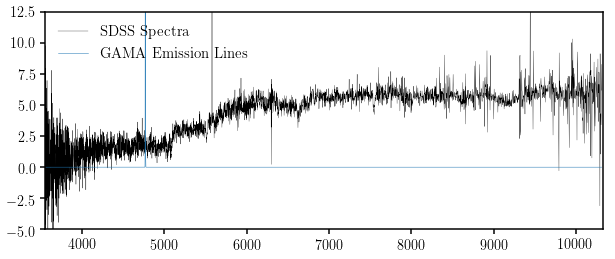

==2==
3818, 55532, 146
z_gama= 0.282980


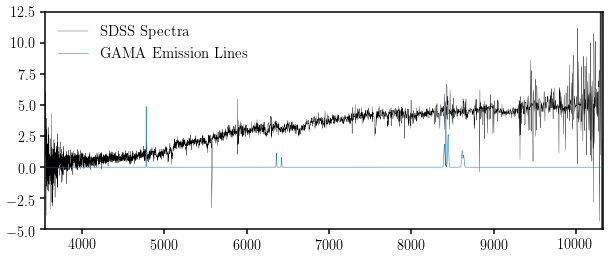

==3==
4021, 55620, 182
z_gama= 0.308000


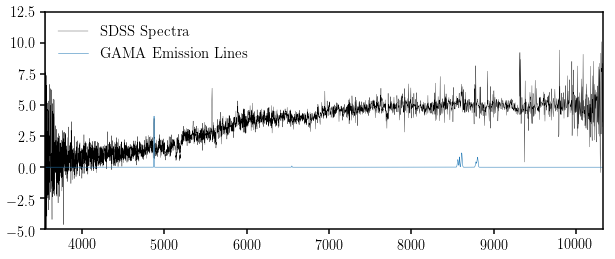

==4==
4729, 55626, 476
z_gama= 0.075770


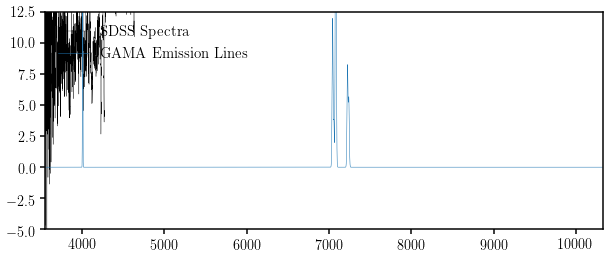

==5==
4748, 55631, 458
z_gama= 0.299170


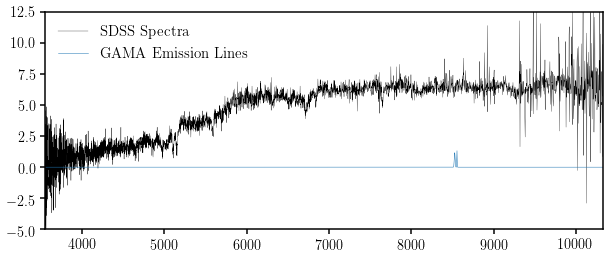

==6==
4031, 55604, 408
z_gama= 0.299930


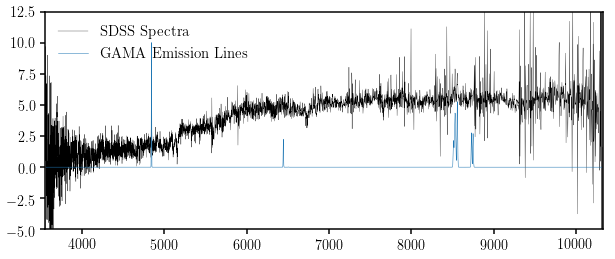

==7==
4750, 55630, 312
z_gama= 0.237580


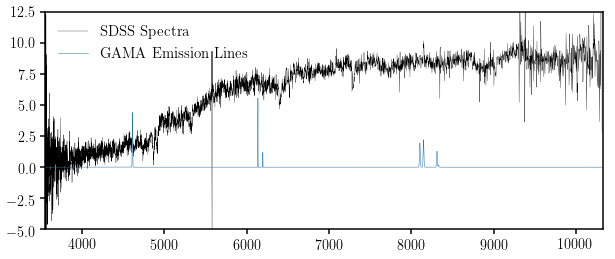

==8==
3777, 55210, 684
z_gama= 0.198720


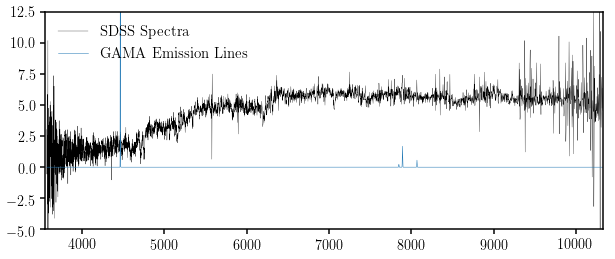

==9==
4025, 55350, 980
z_gama= 0.209530


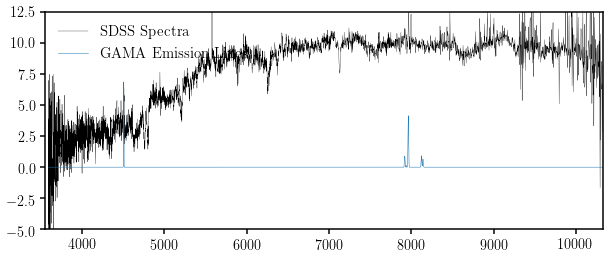

In [111]:
for i in range(10): 
    print('==%i==' % i)
    print('%i, %i, %i' % (f_sdss_emline['plate'].value[m_sdss[i],0], f_sdss_emline['mjd'].value[m_sdss[i],0], f_sdss_emline['fiberid'].value[m_sdss[i],0]))
    print('z_gama= %f' % gleg['gama-spec']['z_helio'][m_gleg[i]])
    fig = plt.figure(figsize=(10,4))
    sub = fig.add_subplot(111)
    sub.plot(10**sdss_specs[i]['loglam'], sdss_specs[i]['flux'], c='k', lw=0.3, label='SDSS Spectra')
    sub.plot(10**sdss_specs[i]['loglam'], justEmLines(10**sdss_specs[i]['loglam'], m_gleg[i]), lw=0.5, 
             label='GAMA Emission Lines')
    sub.legend(loc='upper left', prop={'size':15})
    sub.set_xlim([3550, 10325])
    sub.set_ylim([-5., 12.5])
    plt.show()

In [78]:
def spectraComparison(i_m, em_keys, offsets=None, yrange=[0., 10.]):
    if offsets is None: offsets = np.zeros(len(em_keys))
    fig = plt.figure(figsize=(3*len(em_keys),4))
    for i_k, k in enumerate(em_keys): 
        sub = fig.add_subplot(1,len(em_keys),i_k+1)
        lbl_sdss, lbl_gama_emline, lbl_sdss_emline = None, None, None
        if i_k == 0: lbl_sdss, lbl_gama_emline, lbl_sdss_emline = 'SDSS Spectra', 'GAMA Em.Lines', 'SDSS Em.Lines'
            
        sub.plot(10**sdss_specs[i_m]['loglam'], 
                 justEmLines(10**sdss_specs[i_m]['loglam'], m_gleg[i_m])+offsets[i_k], 
                 c='C1', ls='--', lw=2, label=lbl_gama_emline)
        sub.plot(10**sdss_specs[i_m]['loglam'], 
                 justEmLines_SDSS(10**sdss_specs[i_m]['loglam'], m_gleg[i_m], m_sdss[i_m])+offsets[i_k], 
                 c='C0', ls='--', lw=2, label=lbl_sdss_emline)
        sub.plot(10**sdss_specs[i_m]['loglam'], sdss_specs[i_m]['flux'], c='k', lw=1, label=lbl_sdss)
        z_gama = gleg['gama-spec']['z_helio'][m_gleg[i_m]]
        
        lmid = (1.+z_gama)*emline_lambda[emline_gleg_key.index(k)]
        sub.set_xlim([lmid-100., lmid+100.])
        sub.set_ylim(yrange)
        sub.set_title(k.upper(), fontsize=15)
        if i_k == 0: sub.legend(loc='upper right', prop={'size':15})
    plt.show()

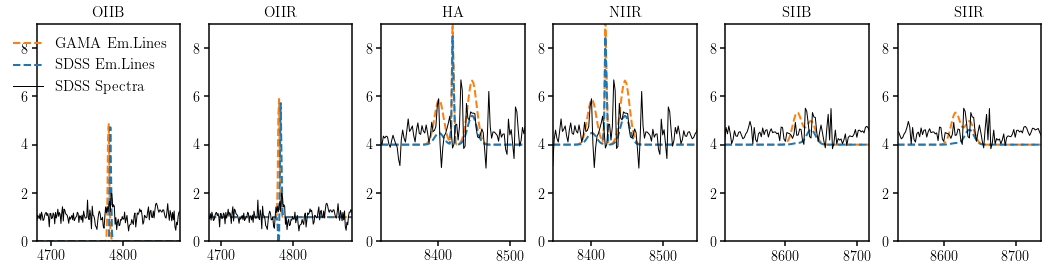

In [79]:
spectraComparison(2, ['oiib', 'oiir', 'ha', 'niir', 'siib', 'siir'], offsets=[0.,1.,4.,4.,4.,4.], yrange=[0,9])

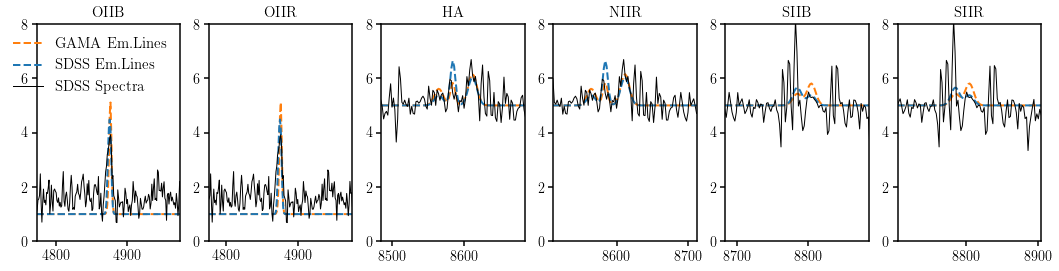

In [80]:
spectraComparison(3, ['oiib', 'oiir', 'ha', 'niir', 'siib', 'siir'], offsets=[1., 1., 5., 5., 5., 5.], yrange=[0,8])

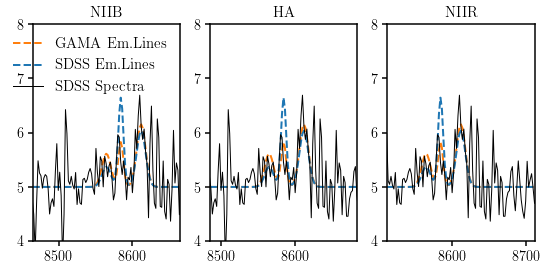

In [119]:
spectraComparison(3, ['niib', 'ha', 'niir'], offsets=[5., 5., 5.], yrange=[4,8])

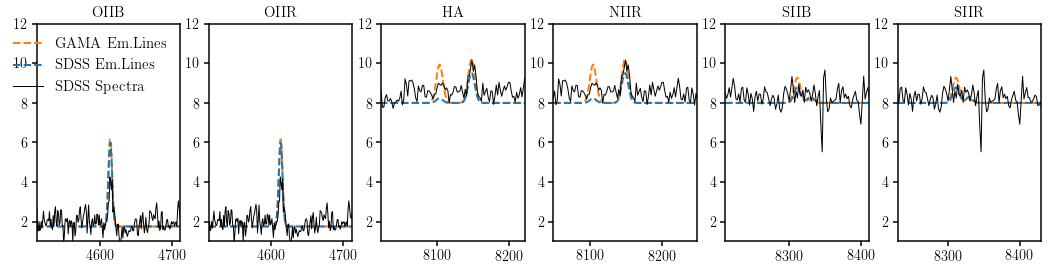

In [123]:
spectraComparison(7, ['oiib', 'oiir', 'ha', 'niir', 'siib', 'siir'], offsets=[1.75, 1.75, 8., 8., 8., 8.], yrange=[1,12])

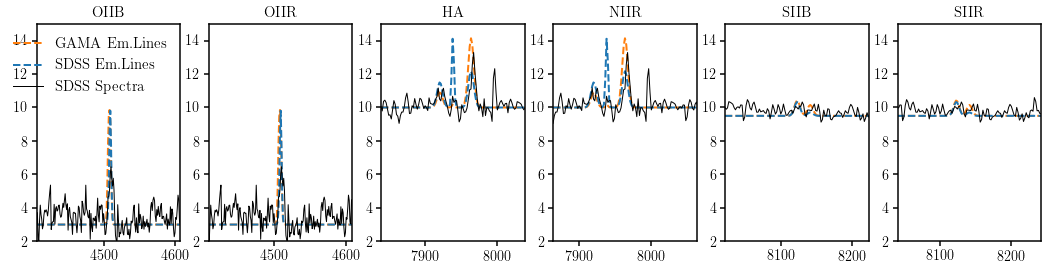

In [99]:
spectraComparison(9, ['oiib', 'oiir', 'ha', 'niir', 'siib', 'siir'], offsets=[3., 3., 10., 10., 9.5, 9.5], yrange=[2.,15.])

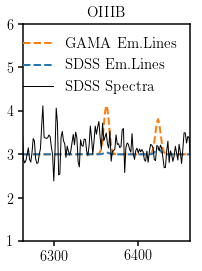

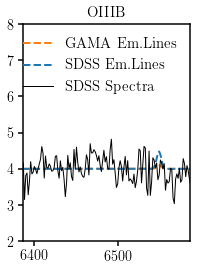

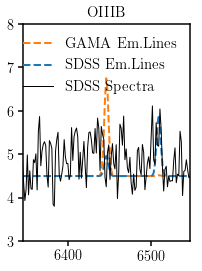

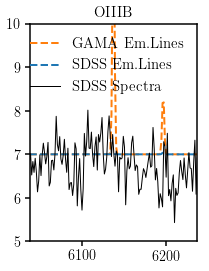

In [117]:
spectraComparison(2, ['oiiib'], offsets=[3], yrange=[1,6])
spectraComparison(3, ['oiiib'], offsets=[4], yrange=[2,8])
spectraComparison(6, ['oiiib'], offsets=[4.5], yrange=[3,8])
spectraComparison(7, ['oiiib'], offsets=[7], yrange=[5,10])